In [67]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [68]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"


INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [69]:
def split_data_into_segments(data, min_duration_seconds=12, frequency=200):
    """
    Split time-indexed sensor data into separate segments with minimum duration requirement.
    
    Parameters:
    data: DataFrame with time index and sensor columns (acc_x, acc_y, acc_z)
    min_duration_seconds: Minimum duration in seconds for each segment
    frequency: Sampling frequency (Hz)
    
    Returns:
    list: List of DataFrames, each containing a segment of the data
    """
    min_samples = min_duration_seconds * frequency
    total_samples = len(data)
    
    # If data is shorter than minimum, return the whole data
    if total_samples < min_samples:
        print(f"Data too short ({total_samples} samples < {min_samples} required). Returning whole data.")
        return [data]
    
    # Calculate how many segments we can create
    num_segments = total_samples // min_samples
    
    segments = []
    
    # Split into equal segments
    for segment_idx in range(num_segments):
        start_idx = segment_idx * min_samples
        end_idx = start_idx + min_samples
        
        segment = data.iloc[start_idx:end_idx].copy()
        segments.append(segment)
    
    print(f"Original data length: {total_samples} samples ({total_samples/frequency:.1f} seconds)")
    print(f"Created {len(segments)} segments of {min_samples} samples ({min_duration_seconds} seconds) each")
    
    return segments



In [70]:
raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [71]:
raw_sisfall_dataset['data'][0]

,acc_x,acc_y,acc_z
2000-01-01 00:00:05.000,-0.003906,-0.886719,-0.421875
2000-01-01 00:00:05.005,-0.019531,-0.859375,-0.398438
2000-01-01 00:00:05.010,-0.046875,-0.820312,-0.390625
2000-01-01 00:00:05.015,-0.062500,-0.808594,-0.386719
2000-01-01 00:00:05.020,-0.082031,-0.824219,-0.351562
...,...,...,...
2000-01-01 00:00:14.975,0.027344,-0.953125,0.121094
2000-01-01 00:00:14.980,0.042969,-0.968750,0.113281
2000-01-01 00:00:14.985,0.042969,-0.968750,0.105469
2000-01-01 00:00:14.990,0.035156,-0.968750,0.121094


In [72]:
def read_file_earpiece(file_path, sensors_axes):
    """
    Reads the data from an activity and convert them into a DataFrame with a corresponding time series to the frequency
    of the sensor.

    :param file_path: the path of the file containing the data of the activity
    :param sensors_axes: the data from which sensors' axes is wanted
    :return: a DataFrame containing the data for one activity
    """

    # Reads the file
    data = pd.read_csv(file_path)
    
    # Selects sensors axes
    data = data.iloc[:, sensors_axes]
    
    # Create time index
    index = pd.date_range('1/1/2000', periods=len(data), freq='5ms')
    data.set_index(index, inplace=True)

    return data


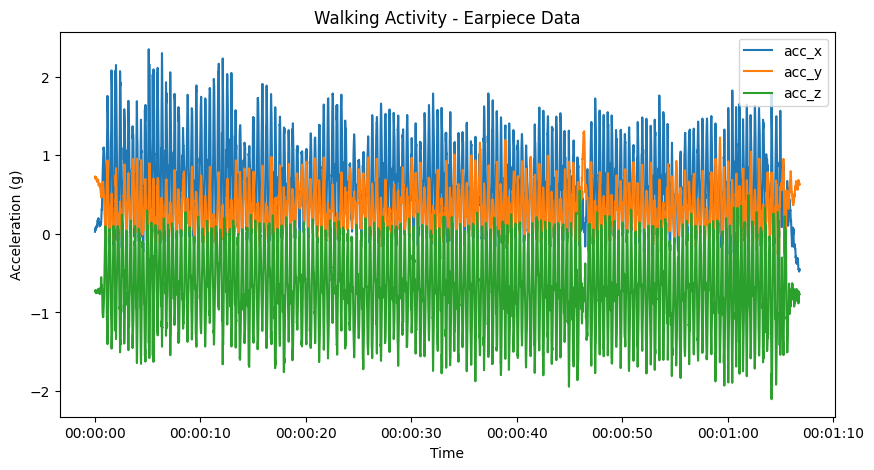

In [73]:
jogging_1 = read_file_earpiece('datasets/earpiece/jogging_1.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})
walking_1 = read_file_earpiece('datasets/earpiece/walking_1.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})
walking_2 = read_file_earpiece('datasets/earpiece/walking_2.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})
walking_3 = read_file_earpiece('datasets/earpiece/walking_3.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})
walking_4 = read_file_earpiece('datasets/earpiece/walking_4.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})

plt.figure(figsize=(10, 5))
plt.plot(jogging_1.index, jogging_1['acc_x'], label='acc_x')
plt.plot(jogging_1.index, jogging_1['acc_y'], label='acc_y')
plt.plot(jogging_1.index, jogging_1['acc_z'], label='acc_z')
plt.title('Walking Activity - Earpiece Data')
plt.xlabel('Time')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.show()

In [74]:
combined_walking = pd.concat([walking_1, walking_2, walking_3, walking_4])
combined_jogging = jogging_1
combined_walking['class'] = 'walking'
combined_jogging['class'] = 'jogging'

In [75]:

segments_jogging = split_data_into_segments(combined_jogging, min_duration_seconds=12, frequency=200)

segments_walking = split_data_into_segments(combined_walking, min_duration_seconds=12, frequency=200)



Original data length: 13365 samples (66.8 seconds)
Created 5 segments of 2400 samples (12 seconds) each
Original data length: 19835 samples (99.2 seconds)
Created 8 segments of 2400 samples (12 seconds) each


In [76]:
segments_jogging

[                            acc_x     acc_y     acc_z    class
 2000-01-01 00:00:00.000  0.026367  0.723145 -0.724609  jogging
 2000-01-01 00:00:00.005  0.029297  0.729980 -0.724609  jogging
 2000-01-01 00:00:00.010  0.032227  0.730957 -0.727051  jogging
 2000-01-01 00:00:00.015  0.047363  0.717285 -0.732422  jogging
 2000-01-01 00:00:00.020  0.043945  0.720703 -0.731934  jogging
 ...                           ...       ...       ...      ...
 2000-01-01 00:00:11.975 -0.052734 -0.059082 -0.055664  jogging
 2000-01-01 00:00:11.980 -0.022949 -0.068848 -0.071777  jogging
 2000-01-01 00:00:11.985  0.025391 -0.069336 -0.118164  jogging
 2000-01-01 00:00:11.990  0.081543 -0.067871 -0.183594  jogging
 2000-01-01 00:00:11.995  0.162598 -0.064941 -0.243164  jogging
 
 [2400 rows x 4 columns],
                             acc_x     acc_y     acc_z    class
 2000-01-01 00:00:12.000  0.244629 -0.057617 -0.308594  jogging
 2000-01-01 00:00:12.005  0.344238 -0.036621 -0.378906  jogging
 2000-01-01 

In [77]:
segments = segments_jogging + segments_walking

In [78]:
segments

[                            acc_x     acc_y     acc_z    class
 2000-01-01 00:00:00.000  0.026367  0.723145 -0.724609  jogging
 2000-01-01 00:00:00.005  0.029297  0.729980 -0.724609  jogging
 2000-01-01 00:00:00.010  0.032227  0.730957 -0.727051  jogging
 2000-01-01 00:00:00.015  0.047363  0.717285 -0.732422  jogging
 2000-01-01 00:00:00.020  0.043945  0.720703 -0.731934  jogging
 ...                           ...       ...       ...      ...
 2000-01-01 00:00:11.975 -0.052734 -0.059082 -0.055664  jogging
 2000-01-01 00:00:11.980 -0.022949 -0.068848 -0.071777  jogging
 2000-01-01 00:00:11.985  0.025391 -0.069336 -0.118164  jogging
 2000-01-01 00:00:11.990  0.081543 -0.067871 -0.183594  jogging
 2000-01-01 00:00:11.995  0.162598 -0.064941 -0.243164  jogging
 
 [2400 rows x 4 columns],
                             acc_x     acc_y     acc_z    class
 2000-01-01 00:00:12.000  0.244629 -0.057617 -0.308594  jogging
 2000-01-01 00:00:12.005  0.344238 -0.036621 -0.378906  jogging
 2000-01-01 

In [105]:
segments[0]

,acc_x,acc_y,acc_z,class,mag_acc,mag_cla
2000-01-01 00:00:00.000,0.026367,0.723145,-0.724609,jogging,1.024057,1.773718
2000-01-01 00:00:00.005,0.029297,0.729980,-0.724609,jogging,1.028975,1.782236
2000-01-01 00:00:00.010,0.032227,0.730957,-0.727051,jogging,1.031474,1.786566
2000-01-01 00:00:00.015,0.047363,0.717285,-0.732422,jogging,1.026247,1.777512
2000-01-01 00:00:00.020,0.043945,0.720703,-0.731934,jogging,1.028140,1.780790
...,...,...,...,...,...,...
2000-01-01 00:00:11.975,-0.052734,-0.059082,-0.055664,jogging,0.096799,0.167661
2000-01-01 00:00:11.980,-0.022949,-0.068848,-0.071777,jogging,0.102072,0.176794
2000-01-01 00:00:11.985,0.025391,-0.069336,-0.118164,jogging,0.139337,0.241339
2000-01-01 00:00:11.990,0.081543,-0.067871,-0.183594,jogging,0.212043,0.367270


In [80]:
# prepared_walking_data = change_activity_duration(new_read, 10000)
# prepared_walking_data = change_activity_sampling(new_read, 200)
# prepared_walking_data = prepared_walking_data.rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})

In [110]:
activity_label = ['walking','jogging']  # or replace with a list if you have multiple labels

# Build the final dataframe
# Check if we're using one label or multiple labels
if isinstance(activity_label, str):
    # Filter segments to keep only those with matching class if specified
    if activity_label != '':
        filtered_segments = [seg for seg in segments if seg['class'].iloc[0] == activity_label]
    else:
        filtered_segments = segments
else:
    # Handle list of activities
    filtered_segments = [seg for seg in segments if seg['class'].iloc[0] in activity_label]

# Build the final dataframe
df_segments = pd.DataFrame({
    'class': [segment['class'].iloc[0] for segment in filtered_segments],
    'data': filtered_segments
})



In [102]:
df_segments['data'][0]

,acc_x,acc_y,acc_z,class,mag_acc,mag_cla
2000-01-01 00:00:00.000,0.026367,0.723145,-0.724609,jogging,1.024057,1.773718
2000-01-01 00:00:00.005,0.029297,0.729980,-0.724609,jogging,1.028975,1.782236
2000-01-01 00:00:00.010,0.032227,0.730957,-0.727051,jogging,1.031474,1.786566
2000-01-01 00:00:00.015,0.047363,0.717285,-0.732422,jogging,1.026247,1.777512
2000-01-01 00:00:00.020,0.043945,0.720703,-0.731934,jogging,1.028140,1.780790
...,...,...,...,...,...,...
2000-01-01 00:00:11.975,-0.052734,-0.059082,-0.055664,jogging,0.096799,0.167661
2000-01-01 00:00:11.980,-0.022949,-0.068848,-0.071777,jogging,0.102072,0.176794
2000-01-01 00:00:11.985,0.025391,-0.069336,-0.118164,jogging,0.139337,0.241339
2000-01-01 00:00:11.990,0.081543,-0.067871,-0.183594,jogging,0.212043,0.367270


In [ ]:
features_list = []
final_df = pd.DataFrame()
for index, row in df_segments.iterrows():
    print(f"Processing segment {index+1}/{len(df_segments)}: {row['data']}")
    # Extract features from the segment
    # print(row[1]['acc_x'])
    segment = row['data']
    features = extract_features(segment ,with_magnitude=True)
    features['class'] = row['class']
    features['binary'] = 'adl' if row['class'] != 'fall' else 'fall'
    features_list.append(features)
    final_df = pd.concat(features_list, ignore_index=True)

Processing segment 1/13:                             acc_x     acc_y     acc_z    class   mag_acc  \
2000-01-01 00:00:00.000  0.026367  0.723145 -0.724609  jogging  1.024057   
2000-01-01 00:00:00.005  0.029297  0.729980 -0.724609  jogging  1.028975   
2000-01-01 00:00:00.010  0.032227  0.730957 -0.727051  jogging  1.031474   
2000-01-01 00:00:00.015  0.047363  0.717285 -0.732422  jogging  1.026247   
2000-01-01 00:00:00.020  0.043945  0.720703 -0.731934  jogging  1.028140   
...                           ...       ...       ...      ...       ...   
2000-01-01 00:00:11.975 -0.052734 -0.059082 -0.055664  jogging  0.096799   
2000-01-01 00:00:11.980 -0.022949 -0.068848 -0.071777  jogging  0.102072   
2000-01-01 00:00:11.985  0.025391 -0.069336 -0.118164  jogging  0.139337   
2000-01-01 00:00:11.990  0.081543 -0.067871 -0.183594  jogging  0.212043   
2000-01-01 00:00:11.995  0.162598 -0.064941 -0.243164  jogging  0.299640   

                          mag_cla  
2000-01-01 00:00:00.000  1

TypeError: Could not convert ['joggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjoggingjogging'] to numeric

In [ ]:
final_df

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,binary
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217,walking,adl
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022,walking,adl
2,-0.068094,0.377883,-0.662161,1.007205,0.294981,0.020401,0.128963,0.015772,0.543121,0.142832,...,-0.417114,0.270996,-0.899536,0.942413,0.332886,0.480103,-0.521484,1.045332,walking,adl
3,-0.065519,0.423517,-0.800523,0.996898,0.124288,0.019128,0.028504,0.002612,0.352545,0.138305,...,-0.502075,0.406250,-0.898438,0.985384,0.126953,0.429199,-0.737549,1.005175,walking,adl
4,-0.596021,0.521301,-0.564591,1.007256,0.029755,0.024472,0.022109,0.007531,0.172495,0.156435,...,-0.698242,0.386230,-0.658203,0.957774,-0.527222,0.660645,-0.470215,1.045465,walking,adl
5,-0.830594,0.503740,-0.093720,1.014378,0.031186,0.013578,0.041344,0.009569,0.176596,0.116524,...,-0.904297,0.443359,-0.202148,0.951343,-0.789429,0.557617,0.010254,1.057223,walking,adl
6,-0.804641,0.565227,-0.163788,1.013306,0.008782,0.015310,0.020204,0.011262,0.093710,0.123735,...,-0.853516,0.475098,-0.274536,0.954140,-0.743164,0.651855,-0.066895,1.051187,walking,adl
7,-0.770221,0.588772,-0.191806,1.010614,0.016549,0.021397,0.022268,0.015555,0.128644,0.146277,...,-0.854004,0.474121,-0.306274,0.942747,-0.686401,0.682129,-0.068726,1.057496,walking,adl


In [ ]:
Y_test_adl = final_df['class']
Y_test_binary = final_df['binary']

X_test = final_df.drop(columns=['class', 'binary'])

In [ ]:
X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,1.018066,1.621040,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,1.023926,1.398258,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022
2,-0.068094,0.377883,-0.662161,1.007205,0.294981,0.020401,0.128963,0.015772,0.543121,0.142832,...,1.798828,1.268497,-0.417114,0.270996,-0.899536,0.942413,0.332886,0.480103,-0.521484,1.045332
3,-0.065519,0.423517,-0.800523,0.996898,0.124288,0.019128,0.028504,0.002612,0.352545,0.138305,...,0.875977,0.837389,-0.502075,0.406250,-0.898438,0.985384,0.126953,0.429199,-0.737549,1.005175
4,-0.596021,0.521301,-0.564591,1.007256,0.029755,0.024472,0.022109,0.007531,0.172495,0.156435,...,0.988281,0.777335,-0.698242,0.386230,-0.658203,0.957774,-0.527222,0.660645,-0.470215,1.045465
5,-0.830594,0.503740,-0.093720,1.014378,0.031186,0.013578,0.041344,0.009569,0.176596,0.116524,...,1.497559,0.856059,-0.904297,0.443359,-0.202148,0.951343,-0.789429,0.557617,0.010254,1.057223
6,-0.804641,0.565227,-0.163788,1.013306,0.008782,0.015310,0.020204,0.011262,0.093710,0.123735,...,0.881836,0.934888,-0.853516,0.475098,-0.274536,0.954140,-0.743164,0.651855,-0.066895,1.051187
7,-0.770221,0.588772,-0.191806,1.010614,0.016549,0.021397,0.022268,0.015555,0.128644,0.146277,...,0.786133,1.217528,-0.854004,0.474121,-0.306274,0.942747,-0.686401,0.682129,-0.068726,1.057496


In [ ]:
rf_model_binary = joblib.load('models/rf_model_combined_binary.pkl')
rf_combined_adl = joblib.load('models/rf_model_combined_adl.pkl')
dt_combined_adl = joblib.load('models/dt_model_combined_adl.pkl')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

In [ ]:
X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,1.018066,1.621040,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,1.023926,1.398258,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022
2,-0.068094,0.377883,-0.662161,1.007205,0.294981,0.020401,0.128963,0.015772,0.543121,0.142832,...,1.798828,1.268497,-0.417114,0.270996,-0.899536,0.942413,0.332886,0.480103,-0.521484,1.045332
3,-0.065519,0.423517,-0.800523,0.996898,0.124288,0.019128,0.028504,0.002612,0.352545,0.138305,...,0.875977,0.837389,-0.502075,0.406250,-0.898438,0.985384,0.126953,0.429199,-0.737549,1.005175
4,-0.596021,0.521301,-0.564591,1.007256,0.029755,0.024472,0.022109,0.007531,0.172495,0.156435,...,0.988281,0.777335,-0.698242,0.386230,-0.658203,0.957774,-0.527222,0.660645,-0.470215,1.045465
5,-0.830594,0.503740,-0.093720,1.014378,0.031186,0.013578,0.041344,0.009569,0.176596,0.116524,...,1.497559,0.856059,-0.904297,0.443359,-0.202148,0.951343,-0.789429,0.557617,0.010254,1.057223
6,-0.804641,0.565227,-0.163788,1.013306,0.008782,0.015310,0.020204,0.011262,0.093710,0.123735,...,0.881836,0.934888,-0.853516,0.475098,-0.274536,0.954140,-0.743164,0.651855,-0.066895,1.051187
7,-0.770221,0.588772,-0.191806,1.010614,0.016549,0.021397,0.022268,0.015555,0.128644,0.146277,...,0.786133,1.217528,-0.854004,0.474121,-0.306274,0.942747,-0.686401,0.682129,-0.068726,1.057496


In [ ]:
import numpy as np


def evaluate_model_binary(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique([*y_test, *y_pred]))

    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()



In [ ]:
rf_model_binary.predict(X_test)

array(['adl', 'adl', 'adl', 'adl', 'adl', 'adl', 'adl', 'adl'],
      dtype=object)

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       1.00      1.00      1.00         8

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Confusion Matrix:
Accuracy: 1.0000



/Users/amir/Downloads/fall-detection-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


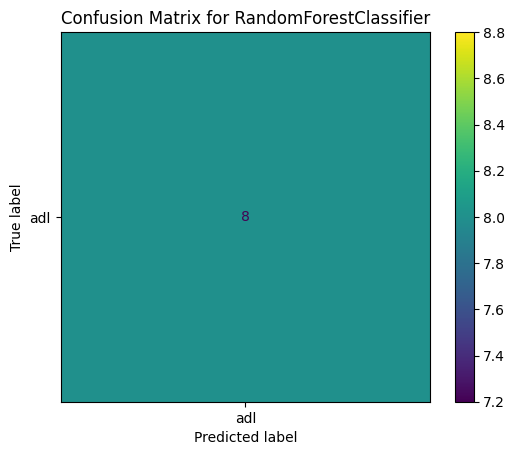

In [ ]:
evaluate_model_binary(rf_model_binary, X_test, Y_test_binary)

In [ ]:
# Get the classes that the model was trained on
import numpy as np

Y_test = final_df['class']

model_classes = rf_combined_adl.classes_

# Create a modified evaluate function that handles single-class test data
def evaluate_single_class(model, X_test, y_test):
	y_pred = model.predict(X_test)
	print(f"Model: {model.__class__.__name__}")
	print(f"Predictions: {y_pred}")
	print(f"Actual values: {y_test.values}")
	
	# Calculate accuracy for the predictions
	accuracy = (y_pred == y_test).mean()
	print(f"Accuracy: {accuracy:.4f}")
	
	# Print which ADL class the model predicts for the walking data
	print("\nPrediction distribution:")
	unique_preds, counts = np.unique(y_pred, return_counts=True)
	for pred, count in zip(unique_preds, counts):
		print(f"  {pred}: {count} samples ({count/len(y_pred)*100:.1f}%)")

# Use the modified evaluation function for single-class data
evaluate_single_class(rf_combined_adl, X_test, Y_test)

Model: RandomForestClassifier
Predictions: ['walking' 'walking' 'fall' 'fall' 'sitting' 'sitting' 'sitting' 'walking']
Actual values: ['walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking']
Accuracy: 0.3750

Prediction distribution:
  fall: 2 samples (25.0%)
  sitting: 3 samples (37.5%)
  walking: 3 samples (37.5%)


In [ ]:
# Get the classes that the model was trained on
import numpy as np

Y_test = final_df['class']

model_classes = rf_combined_adl.classes_

# Create a modified evaluate function that handles single-class test data
def evaluate_single_class(model, X_test, y_test):
	y_pred = model.predict(X_test)
	print(f"Model: {model.__class__.__name__}")
	print(f"Predictions: {y_pred}")
	print(f"Actual values: {y_test.values}")
	
	# Calculate accuracy for the predictions
	accuracy = (y_pred == y_test).mean()
	print(f"Accuracy: {accuracy:.4f}")
	
	# Print which ADL class the model predicts for the walking data
	print("\nPrediction distribution:")
	unique_preds, counts = np.unique(y_pred, return_counts=True)
	for pred, count in zip(unique_preds, counts):
		print(f"  {pred}: {count} samples ({count/len(y_pred)*100:.1f}%)")

# Use the modified evaluation function for single-class data
evaluate_single_class(dt_combined_adl, X_test, Y_test)

Model: DecisionTreeClassifier
Predictions: ['walking' 'walking' 'sitting' 'fall' 'walking' 'sitting' 'sitting'
 'walking']
Actual values: ['walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking']
Accuracy: 0.5000

Prediction distribution:
  fall: 1 samples (12.5%)
  sitting: 3 samples (37.5%)
  walking: 4 samples (50.0%)
